In [19]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
%matplotlib notebook

In [20]:
cameras_file = os.path.join("../Desktop/Archive", "red-light-camera-locations.csv")
speedings_file = os.path.join("../Desktop/Archive","speed-camera-violations.csv")

In [21]:
red_locs_df = pd.read_csv(cameras_file)
del red_locs_df["Third Approach"]
speedings_df = pd.read_csv(speedings_file)

In [22]:
cams_per_ward = pd.DataFrame(red_locs_df.groupby("Wards")["Intersection"].count())
cams_per_ward.head()

,Intersection
Wards,
1,2
2,2
3,2
4,1
5,1


In [23]:
violations_per_ward = pd.DataFrame(speedings_df.groupby("Wards")["Violations"].sum())
violations_per_ward.head()

,Violations
Wards,
1.0,133599
2.0,80740
3.0,76211
4.0,332224
6.0,24005


In [24]:
merge_df = pd.merge(cams_per_ward, violations_per_ward, on="Wards")
merge_df = merge_df.rename(columns={
    "Intersection": "Number of Red Light Cams per Ward",
    "Violations": "Number of Speeding Violations per Ward"
})
merge_df.head()

,Number of Red Light Cams per Ward,Number of Speeding Violations per Ward
Wards,,
1,2,133599
2,2,80740
3,2,76211
4,1,332224
6,1,24005


In [25]:
def to_linear_regress(x, y, weight, arrangement, cmap):
    pearson_r = round(st.pearsonr(x, y)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)}x + {round(intercept, 2)}"
    plt.scatter(x, y, s=weight, c=arrangement, cmap=cmap)
    plt.plot(x,regress_values,"r-")
    print(f"correlation coefficient : {pearson_r}")
    return line_eq

In [26]:
def to_annotate(line_eq, x, y):
    plt.annotate(line_eq,(x,y),fontsize=13,color="red")

<IPython.core.display.Javascript object>


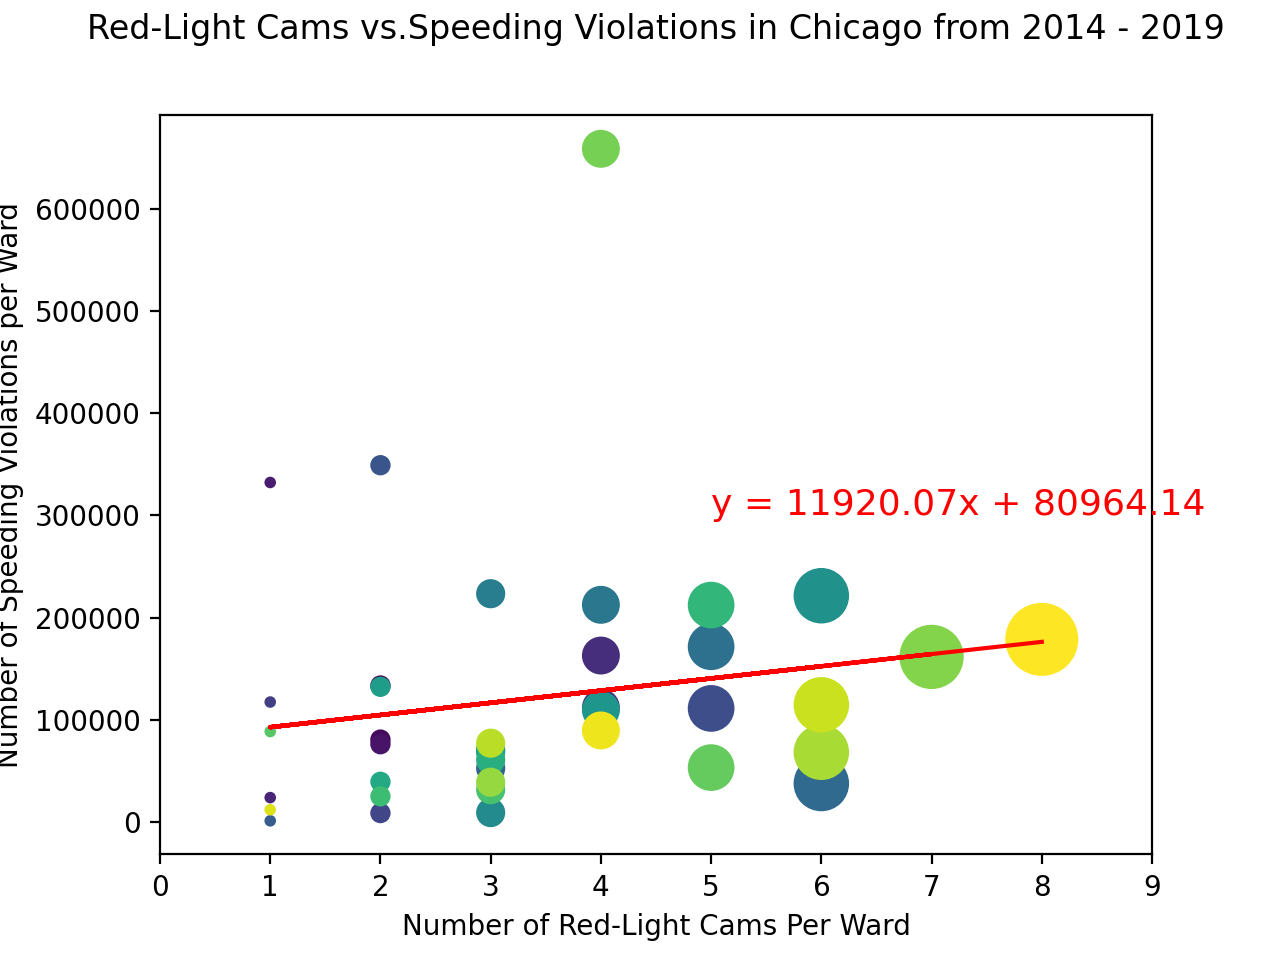

correlation coefficient : 0.18


In [27]:
weight= 10 * (merge_df["Number of Red Light Cams per Ward"]**2)
arrangement=np.arange(len(merge_df["Number of Red Light Cams per Ward"]))
cmap='viridis' 
line = to_linear_regress(merge_df["Number of Red Light Cams per Ward"], merge_df["Number of Speeding Violations per Ward"], weight, arrangement, cmap)
to_annotate(line, 5, 300000)
plt.xticks(np.arange(0, 10, 1))
plt.xlabel("Number of Red-Light Cams Per Ward")
plt.ylabel("Number of Speeding Violations per Ward")
plt.title("Red-Light Cams vs.Speeding Violations in Chicago from 2014 - 2019", y=1.08)
plt.savefig("Images/right_cams_vs_violations.png")

In [28]:
clean_df = merge_df.copy()

In [29]:
wards = [1,2,3,4,6,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,26,27,29,30,31,32,33,35,36,38,40,41,44,45,46,48,49,50] 

In [30]:
clean_df["Ward Number"] = wards

In [31]:
clean_df.head()

,Number of Red Light Cams per Ward,Number of Speeding Violations per Ward,Ward Number
Wards,,,
1,2,133599,1
2,2,80740,2
3,2,76211,3
4,1,332224,4
6,1,24005,6


In [34]:
weight= 10 * (clean_df["Number of Red Light Cams per Ward"]**2)
arrangement=np.arange(len(clean_df["Number of Red Light Cams per Ward"]))
cmap='viridis'
line = to_linear_regress(clean_df["Ward Number"], clean_df["Number of Speeding Violations per Ward"], weight, arrangement, cmap)
to_annotate(line, 7, 500000)
plt.xticks(np.arange(0, 51, 5))
plt.xlabel("Ward Number (Location)")
plt.ylabel("Number of Speeding Violations per Ward")
plt.title("Ward Location vs.Speeding Violations in Chicago from 2014 - 2019", y=1.08)
plt.savefig("Images/location_vs._violations.png")

<IPython.core.display.Javascript object>

correlation coefficient : -0.02


In [15]:
clean_df.columns

Index(['Number of Red Light Cams per Ward',
       'Number of Speeding Violations per Ward', 'Ward Number'],
      dtype='object')

<IPython.core.display.Javascript object>


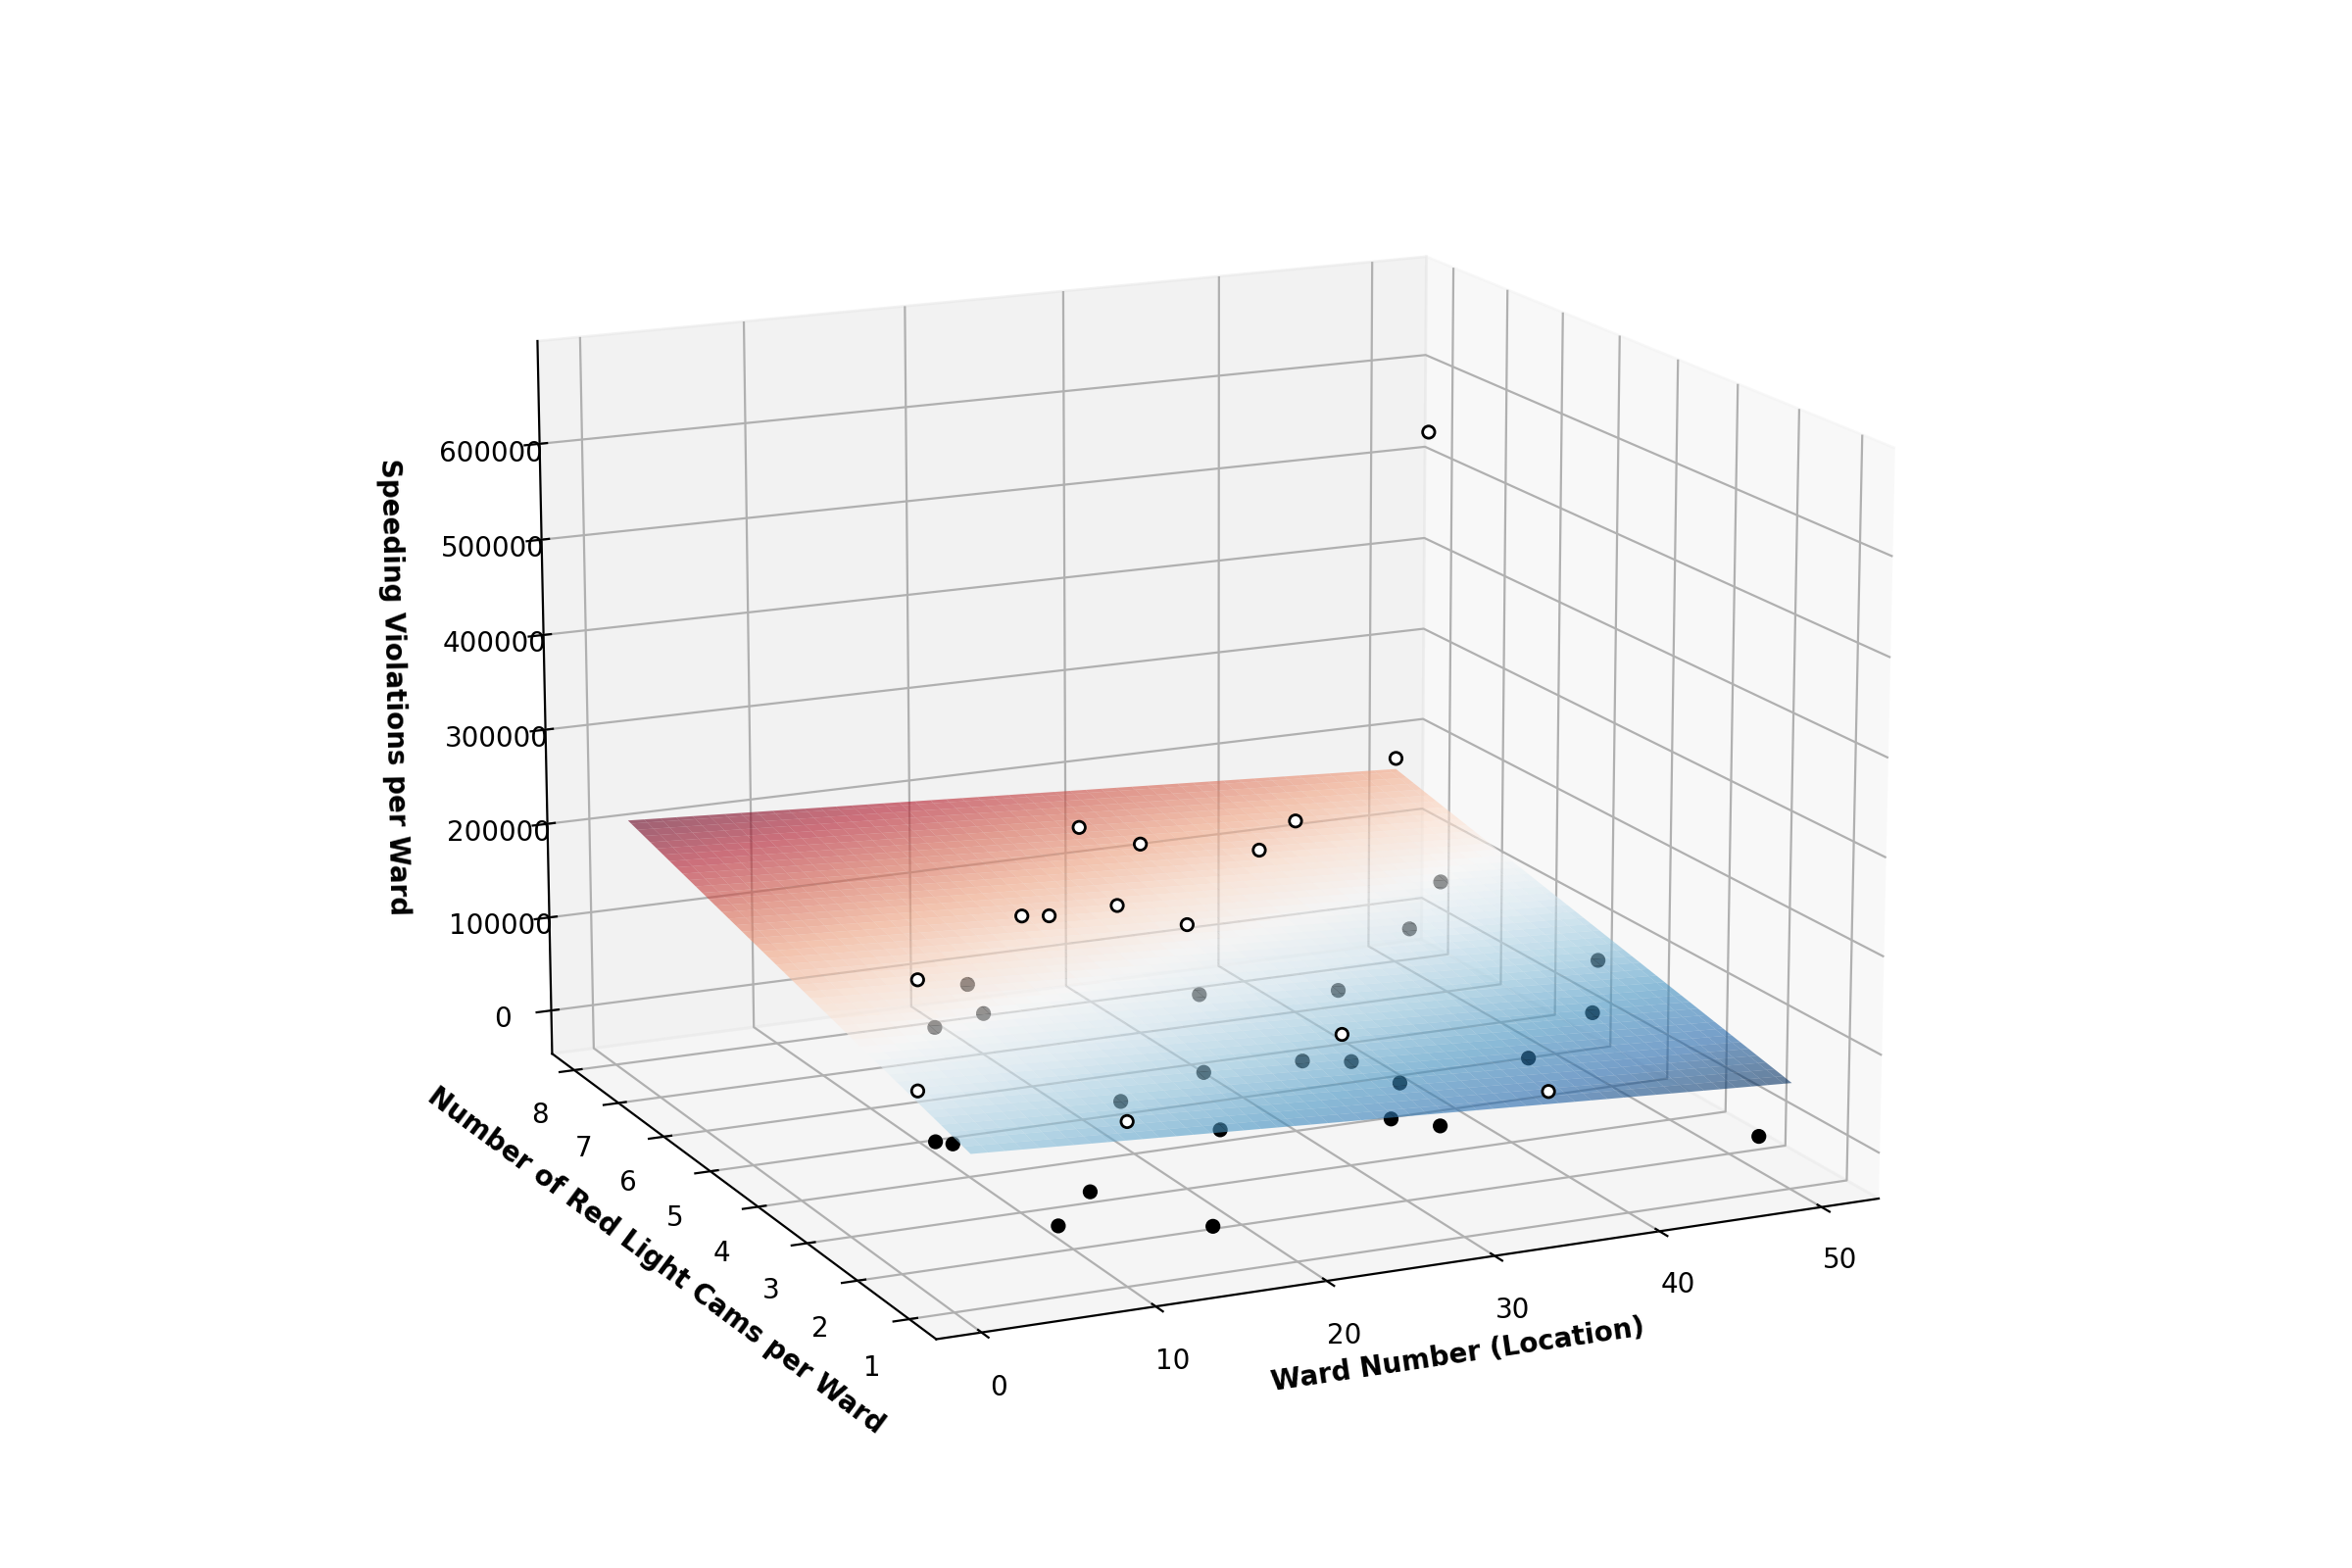

Text(0.5, 0, 'Speeding Violations per Ward')

In [35]:
X = clean_df[["Ward Number", "Number of Red Light Cams per Ward"]]
y = clean_df["Number of Speeding Violations per Ward"]

## fit a OLS model with intercept on Ward Number and Number of Red Light Cams
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot -- skip reading this
xx1, xx2 = np.meshgrid(np.linspace(X["Ward Number"].min(), X["Ward Number"].max(), 100),
np.linspace(X["Number of Red Light Cams per Ward"].min(), X["Number of Red Light Cams per Ward"].max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0]["Ward Number"], X[resid >= 0]["Number of Red Light Cams per Ward"], y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0]["Ward Number"], X[resid < 0]["Number of Red Light Cams per Ward"], y[resid < 0], color='black', alpha=1.0)

# set axis labels
ax.set_xlabel('Ward Number (Location)',fontweight="bold")
ax.set_ylabel('Number of Red Light Cams per Ward',fontweight="bold")
ax.set_zlabel('Speeding Violations per Ward', fontweight="bold", labelpad=15)